In [1]:
%matplotlib inline
import numpy as n
import pylab as p

import matplotlib as mpl
mpl.rcParams["savefig.dpi"] = 120

# Do you want to use the python or the c/cuda KDE version?

In [2]:
version = "pykde"
#version = "cudakde"

if version == "pykde":
    from kde.pykde import gaussian_kde, bootstrap_kde
elif version == "cudakde":
    from kde.cudakde import gaussian_kde, bootstrap_kde

# Define a data model and generate some random data between 0 and 10

#### Number of trials

In [3]:
ntrials = int(1e2)

### Exponential Model

In [4]:
expec = lambda x: 1./(n.exp(-10)-1.)**2 * n.exp(-x)

### Generated data and reweighted to the exponential model

In [5]:
#sampling_method = "uniform"
sampling_method = "exponential"

if sampling_method == "uniform":
    # uniformly generated data and weights
    x1 = n.random.uniform(0,10,ntrials)
    x1_weights = n.exp(-x1)
elif sampling_method == "exponential":
    # exponentially generated data and weights
    x1 = n.random.exponential(2,ntrials)
    x1_weights = n.exp(-0.5*x1)

### Exponentially generated data (w/o weights)

In [6]:
x2 = n.random.exponential(1,ntrials)

# Get histograms

#### Define bins

In [7]:
bins = n.linspace(0,10,31)

### Weighted data

In [8]:
hist_weights = n.histogram(x1,bins=bins,weights=x1_weights,density=True)

### Exponential data

In [9]:
hist_expo = n.histogram(x2,bins=bins,density=True)

# Get KDE kernels

#### Set method to define bandwidth

In [10]:
bw_method="silverman"
#bw_method="scott"

#### Set parameters used for adaptive kernels

In [11]:
adaptive = True # enable adaptive kernels
alpha = 0.3 # found to be a good choice in many cases

#### Set additional parameter if using event weights

In [12]:
weight_adaptive_bw = False # adaptive kernel width determined based on the event statistics (not taking into account the weights)
#weight_adaptive_bw = True # adaptive kernel width determined based on the weighted events 

### Kernels for weighted data (w/o adaptive kernels)

In [13]:
kernel_weights = gaussian_kde(x1,weights=x1_weights,bw_method=bw_method)

### Kernels for weighted data (with adaptive kernels)

In [14]:
kernel_weights_adaptive = gaussian_kde(x1,weights=x1_weights,bw_method=bw_method,adaptive=adaptive,
                                       weight_adaptive_bw=weight_adaptive_bw,alpha=alpha)

### Kernels for exponential data (w/o adaptive kernels)

In [15]:
kernel_expo = gaussian_kde(x2,bw_method=bw_method)

### Kernels for exponential data (with adaptive kernels)

In [16]:
kernel_expo_adaptive = gaussian_kde(x2,bw_method=bw_method,adaptive=adaptive,alpha=alpha)

# Plot histograms and KDEs

#### Define evaluation points

In [17]:
X = n.linspace(0,10,1001)

### Plots for weighted data

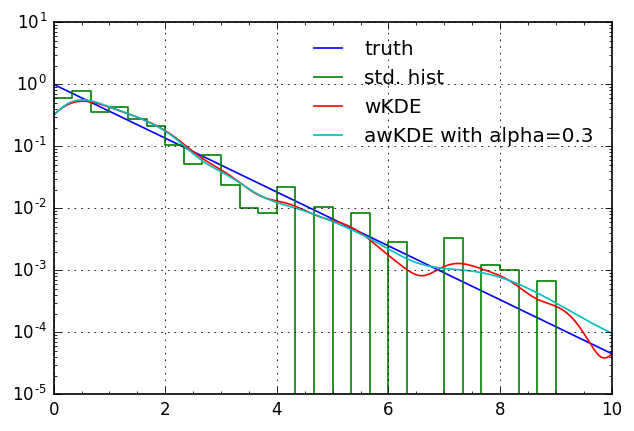

In [18]:
p.figure()
p.grid()
p.minorticks_on()

p.plot(X,expec(X),label="truth")
p.plot(hist_weights[1],n.concatenate((hist_weights[0],hist_weights[0][-1:])),linestyle="steps-post",label="std. hist")
p.plot(X,kernel_weights(X),label="wKDE")
p.plot(X,kernel_weights_adaptive(X),label="awKDE with alpha={0}".format(alpha))

p.yscale("log", nonposy='clip')
p.ylim(ymin=1e-5)
p.legend(loc="best",frameon=False)

### Plots for exponential data

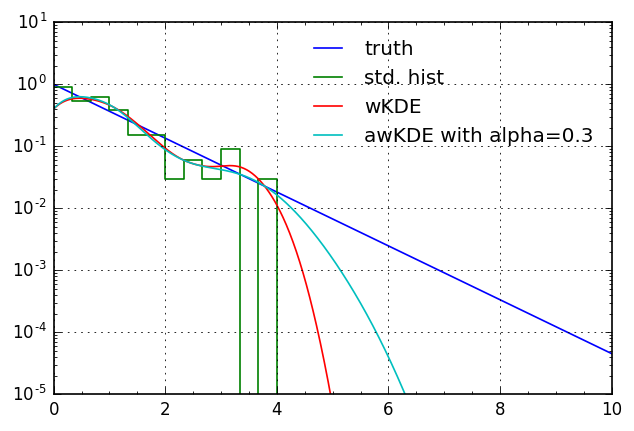

In [19]:
p.figure()
p.grid()
p.minorticks_on()

p.plot(X,expec(X),label="truth")
p.plot(hist_expo[1],n.concatenate((hist_expo[0],hist_expo[0][-1:])),linestyle="steps-post",label="std. hist")
p.plot(X,kernel_expo(X),label="wKDE")
p.plot(X,kernel_expo_adaptive(X),label="awKDE with alpha={0}".format(alpha))

p.yscale("log", nonposy='clip')
p.ylim(ymin=1e-5)
p.legend(loc="best",frameon=False)

# In presence of boundaries reflect the KDEs at the boundary

#### Define reflection range

In [20]:
x_below = (-2.,0.)
x_above = (10.,12.) # refelection only necessary if data is uniformly generated between 0 and 10

#### Define evaluation points beyond the boundaries (below 0 and above 10)

In [21]:
mask_below = (X <= (x_below[1]-(x_below[0]-x_below[1])))
X_below = x_below[1] - (X[mask_below] - x_below[1])

mask_above = (X >= (x_above[0]-(x_above[1]-x_above[0])))
X_above = x_above[0] + (x_above[0] - X[mask_above])

### Plots for weighted data using reflection

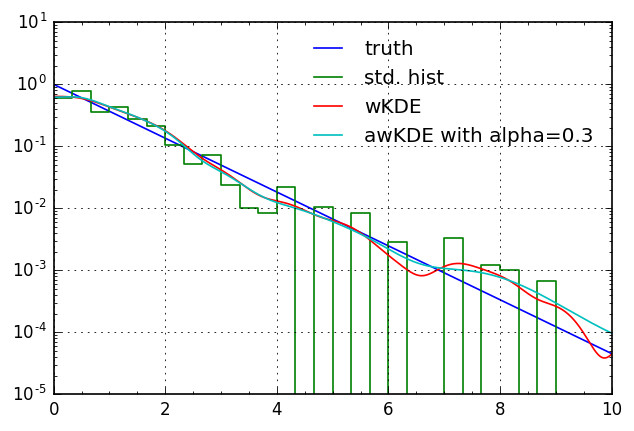

In [22]:
p.figure()
p.grid()
p.minorticks_on()

p.plot(X,expec(X),label="truth")
p.plot(hist_weights[1],n.concatenate((hist_weights[0],hist_weights[0][-1:])),linestyle="steps-post",label="std. hist")

Y_weights = kernel_weights(X)
Y_weights[mask_below] += kernel_weights(X_below)
if sampling_method == "uniform":
    Y_weights[mask_above] += kernel_weights(X_above)
p.plot(X,Y_weights,label="wKDE")

Y_weights_adaptive = kernel_weights_adaptive(X)
Y_weights_adaptive[mask_below] += kernel_weights_adaptive(X_below)
if sampling_method == "uniform":
    Y_weights_adaptive[mask_above] += kernel_weights_adaptive(X_above)
p.plot(X,Y_weights_adaptive,label="awKDE with alpha={0}".format(alpha))

p.yscale("log", nonposy='clip')
p.ylim(ymin=1e-5)
p.legend(loc="best",frameon=False)

### Plots for exponential data

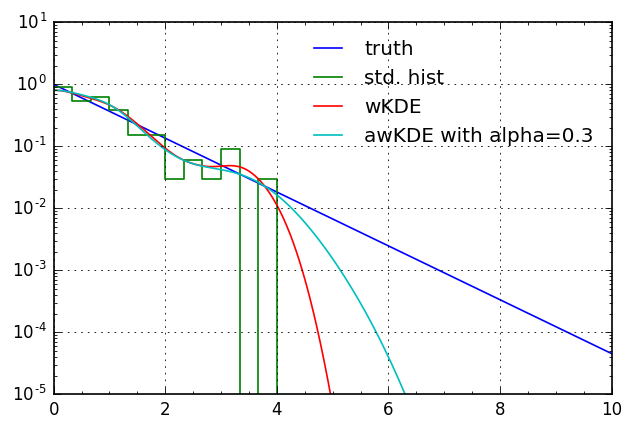

In [23]:
p.figure()
p.grid()
p.minorticks_on()

p.plot(X,expec(X),label="truth")
p.plot(hist_expo[1],n.concatenate((hist_expo[0],hist_expo[0][-1:])),linestyle="steps-post",label="std. hist")

Y_expo = kernel_expo(X)
Y_expo[mask_below] += kernel_expo(X_below)
p.plot(X,Y_expo,label="wKDE")

Y_expo_adaptive = kernel_expo_adaptive(X)
Y_expo_adaptive[mask_below] += kernel_expo_adaptive(X_below)
p.plot(X,Y_expo_adaptive,label="awKDE with alpha={0}".format(alpha))

p.yscale("log", nonposy='clip')
p.ylim(ymin=1e-5)
p.legend(loc="best",frameon=False)

# For an error estimate on an evaluation point use bootstrapping

#### Define the number of bootstrap iterations

In [24]:
nbootstraps = 1000

# Get bootstrapped KDE kernels (settings as set above)

### Kernels for weighted data (w/o adaptive kernels)

In [25]:
bootstrap_kernel_weights = bootstrap_kde(x1,weights=x1_weights,bw_method=bw_method,niter=nbootstraps)

### Kernels for weighted data (with adaptive kernels)

In [26]:
bootstrap_kernel_weights_adaptive = bootstrap_kde(x1,weights=x1_weights,bw_method=bw_method,adaptive=adaptive,
                                                  weight_adaptive_bw=weight_adaptive_bw,alpha=alpha,niter=nbootstraps)

### Kernels for exponential data (w/o adaptive kernels)

In [27]:
bootstrap_kernel_expo = bootstrap_kde(x2,bw_method=bw_method,niter=nbootstraps)

### Kernels for exponential data (with adaptive kernels)

In [28]:
bootstrap_kernel_expo_adaptive = bootstrap_kde(x2,bw_method=bw_method,adaptive=adaptive,alpha=alpha,niter=nbootstraps)

# Plots using reflection and bootstrapping

### Plots for weighted data

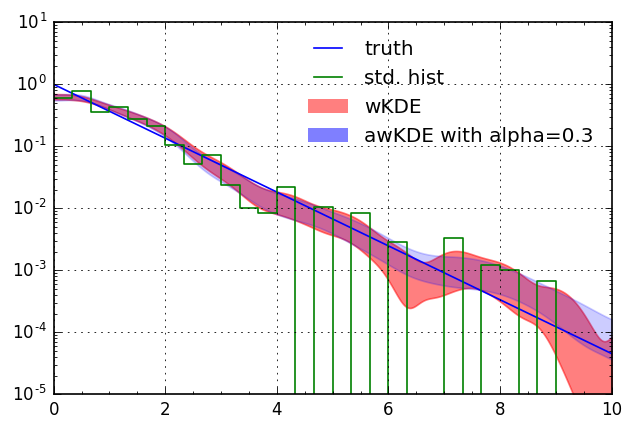

In [29]:
p.figure()
p.grid()
p.minorticks_on()

lines,labels = [],[]

line1 = p.plot(X,expec(X))
lines.append(line1[0])
labels.append("truth")

line2 = p.plot(hist_weights[1],n.concatenate((hist_weights[0],hist_weights[0][-1:])),linestyle="steps-post")
lines.append(line2[0])
labels.append("std. hist")


Y_weights = bootstrap_kernel_weights(X)
Y_weights_below = bootstrap_kernel_weights(X_below)
Y_weights_above = bootstrap_kernel_weights(X_above)

Y_weights[0][mask_below] += Y_weights_below[0]
Y_weights[1][mask_below] = n.sqrt(Y_weights[1][mask_below]**2 + Y_weights_below[1]**2)
if sampling_method == "uniform":
    Y_weights[0][mask_above] += Y_weights_above[0]
    Y_weights[1][mask_above] = n.sqrt(Y_weights[1][mask_above]**2 + Y_weights_above[1]**2)
#color = p.gca()._get_lines.color_cycle.next()
color = 'r'
p.fill_between(X,Y_weights[0]-Y_weights[1],Y_weights[0]+Y_weights[1],label="wKDE",alpha=0.5,color=color)
lines.append(p.Rectangle((0,0),1,1,fc=color,linewidth=0,alpha=0.5))
labels.append("wKDE")


Y_weights_adaptive = bootstrap_kernel_weights_adaptive(X)
Y_weights_adaptive_below = bootstrap_kernel_weights_adaptive(X_below)
Y_weights_adaptive_above = bootstrap_kernel_weights_adaptive(X_above)

Y_weights_adaptive[0][mask_below] += Y_weights_adaptive_below[0]
Y_weights_adaptive[1][mask_below] = n.sqrt(Y_weights_adaptive[1][mask_below]**2 + Y_weights_adaptive_below[1]**2)
if sampling_method == "uniform":
    Y_weights_adaptive[0][mask_above] += Y_weights_adaptive_above[0]
    Y_weights_adaptive[1][mask_above] = n.sqrt(Y_weights_adaptive[1][mask_above]**2 + Y_weights_adaptive_above[1]**2)
#color = p.gca()._get_lines.color_cycle.next()
color = 'b'
p.fill_between(X,Y_weights_adaptive[0]-Y_weights_adaptive[1],Y_weights_adaptive[0]+Y_weights_adaptive[1],alpha=0.2,color=color)
lines.append(p.Rectangle((0,0),1,1,fc=color,linewidth=0,alpha=0.5))
labels.append("awKDE with alpha={0}".format(alpha))

p.yscale("log", nonposy='clip')
p.xlim(0,10)
p.ylim(ymin=1e-5)
p.legend(lines,labels,loc="best",frameon=False)

### Plots for exponential data

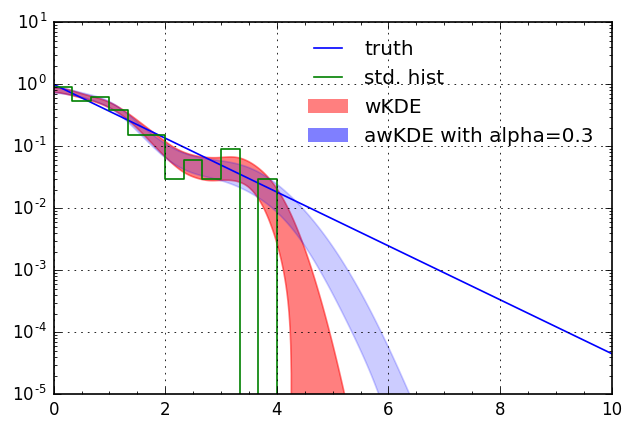

In [30]:
p.figure()
p.grid()
p.minorticks_on()

lines,labels = [],[]

line1 = p.plot(X,expec(X))
lines.append(line1[0])
labels.append("truth")

line2 = p.plot(hist_expo[1],n.concatenate((hist_expo[0],hist_expo[0][-1:])),linestyle="steps-post")
lines.append(line2[0])
labels.append("std. hist")


Y_expo = bootstrap_kernel_expo(X)
Y_expo_below = bootstrap_kernel_expo(X_below)
Y_expo_above = bootstrap_kernel_expo(X_above)

Y_expo[0][mask_below] += Y_expo_below[0]
Y_expo[1][mask_below] = n.sqrt(Y_expo[1][mask_below]**2 + Y_expo_below[1]**2)
#color = p.gca()._get_lines.color_cycle.next()
color = 'r'
p.fill_between(X,Y_expo[0]-Y_expo[1],Y_expo[0]+Y_expo[1],label="wKDE",alpha=0.5,color=color)
lines.append(p.Rectangle((0,0),1,1,fc=color,linewidth=0,alpha=0.5))
labels.append("wKDE")


Y_expo_adaptive = bootstrap_kernel_expo_adaptive(X)
Y_expo_adaptive_below = bootstrap_kernel_expo_adaptive(X_below)
Y_expo_adaptive_above = bootstrap_kernel_expo_adaptive(X_above)

Y_expo_adaptive[0][mask_below] += Y_expo_adaptive_below[0]
Y_expo_adaptive[1][mask_below] = n.sqrt(Y_expo_adaptive[1][mask_below]**2 + Y_expo_adaptive_below[1]**2)
#color = p.gca()._get_lines.color_cycle.next()
color = 'b'
p.fill_between(X,Y_expo_adaptive[0]-Y_expo_adaptive[1],Y_expo_adaptive[0]+Y_expo_adaptive[1],alpha=0.2,color=color)
lines.append(p.Rectangle((0,0),1,1,fc=color,linewidth=0,alpha=0.5))
labels.append("awKDE with alpha={0}".format(alpha))

p.yscale("log", nonposy='clip')
p.xlim(0,10)
p.ylim(ymin=1e-5)
p.legend(lines,labels,loc="best",frameon=False)